# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>
---

**Lab 04**: Data Unions & Joins Pipeline

**Date**: September 23rd 2025

**Student Name**: Aura Melina Gutierrez Jimenez (Ing. en sistemas)

**Professor**: Pablo Camarillo Ramirez

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on SparkSQL") \
    .master("spark://b1ca502cde8a:7077") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/26 13:24:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Build schema
from auragutierrez.spark_utils import SparkUtils

schema_rentals = SparkUtils.generate_schema([("rental_id", "int"), ("rental_info", "string")])
df_rentals = spark.read.schema(schema_rentals).option("header", True).csv("/opt/spark/work-dir/data/car_service/rentals")

schema_agencies = SparkUtils.generate_schema([("agency_id", "int"), ("agency_info", "string")])
df_agencies = spark.read.schema(schema_agencies).option("header", True).csv("/opt/spark/work-dir/data/car_service/agencies")

schema_brands = SparkUtils.generate_schema([("brand_id", "int"), ("brand_info", "string")])
df_brands = spark.read.schema(schema_brands).option("header", True).csv("/opt/spark/work-dir/data/car_service/brands")

schema_cars = SparkUtils.generate_schema([("car_id", "int"), ("car_info", "string")])
df_cars = spark.read.schema(schema_cars).option("header", True).csv("/opt/spark/work-dir/data/car_service/cars")

schema_customers = SparkUtils.generate_schema([("customer_id", "int"), ("customer_info", "string")])
df_customers = spark.read.schema(schema_customers).option("header", True).csv("/opt/spark/work-dir/data/car_service/customers")

In [3]:
from pyspark.sql.functions import get_json_object, col

df_rentals_ids = (df_rentals.withColumn("car_id", get_json_object("rental_info", "$.car_id"))
                            .withColumn("customer_id", get_json_object("rental_info", "$.customer_id"))
                            .withColumn("agency_id", get_json_object("rental_info", "$.agency_id"))
                            .drop("rental_info")
                 )

In [4]:
df_rentals_join = (df_rentals_ids.join(df_cars, on="car_id", how="left")
                     .join(df_customers, on="customer_id", how="left")
                     .join(df_agencies, on="agency_id", how="left")
            )

In [11]:
import pyspark.sql.functions as F
rental_cars_df = (df_rentals_join.select("rental_id", 
                F.get_json_object(F.col("car_info"), "$.car_name").alias("car_name"),
                F.get_json_object(F.col("agency_info"), "$.agency_name").alias("agency_name"),
                F.get_json_object(F.col("customer_info"), "$.customer_name").alias("customer_name")))

In [12]:
rental_cars_df.show(n=5)

+---------+--------------------+-------------+---------------+
|rental_id|            car_name|  agency_name|  customer_name|
+---------+--------------------+-------------+---------------+
|    11891|Wallace-Carlson M...|  NYC Rentals| Margaret Jones|
|    11892|Grimes-Green Model 8|LA Car Rental|Albert Williams|
|    11893|Stewart-Allen Mod...|      SF Cars|  Caleb Fleming|
|    11894|  Campos PLC Model 4|  NYC Rentals|  Andrew Butler|
|    11895|  Wagner LLC Model 1|      SF Cars|  Kristin Potts|
+---------+--------------------+-------------+---------------+
only showing top 5 rows


# Persist data

## Parquet file

In [9]:
!pwd

/opt/spark/work-dir/labs/lab04


In [21]:
!ls ../../data/car_service/output/parquet

ls: cannot access '../../data/car_service/output/parquet': No such file or directory


In [32]:
rental_cars_df.write \
    .mode("overwrite") \
    .parquet("../../data/car_service/output/parquet")

In [33]:
!du -sh ../../data/car_service/output/parquet

124K	../../data/car_service/output/parquet


In [34]:
rental_cars_df.write \
    .partitionBy("agency_name") \
    .mode("overwrite") \
    .parquet("../../data/car_service/output/parquet")

In [27]:
!du -sh ../../data/car_service/output/parquet

144K	../../data/car_service/output/parquet


In [29]:
!ls ../../data/car_service/output/parquet

'agency_name=LA Car Rental'  'agency_name=SF Cars'	  _SUCCESS
'agency_name=NYC Rentals'    'agency_name=Zapopan Auto'


## CSV files

In [38]:
rental_cars_df.write \
    .partitionBy("agency_name") \
    .mode("overwrite") \
    .option("header", True) \
    .csv("../../data/car_service/output/csv")

In [43]:
!ls ../../data/car_service/output/parquet
!du -sh ../../data/car_service/output/csv

'agency_name=LA Car Rental'  'agency_name=SF Cars'	  _SUCCESS
'agency_name=NYC Rentals'    'agency_name=Zapopan Auto'
964K	../../data/car_service/output/csv


In [37]:
rental_cars_df.write \
    .mode("overwrite") \
    .option("header", True) \
    .csv("../../data/car_service/output/csv")

In [42]:
!du -sh ../../data/car_service/output/csv

964K	../../data/car_service/output/csv


In [ ]:
sc.stop()

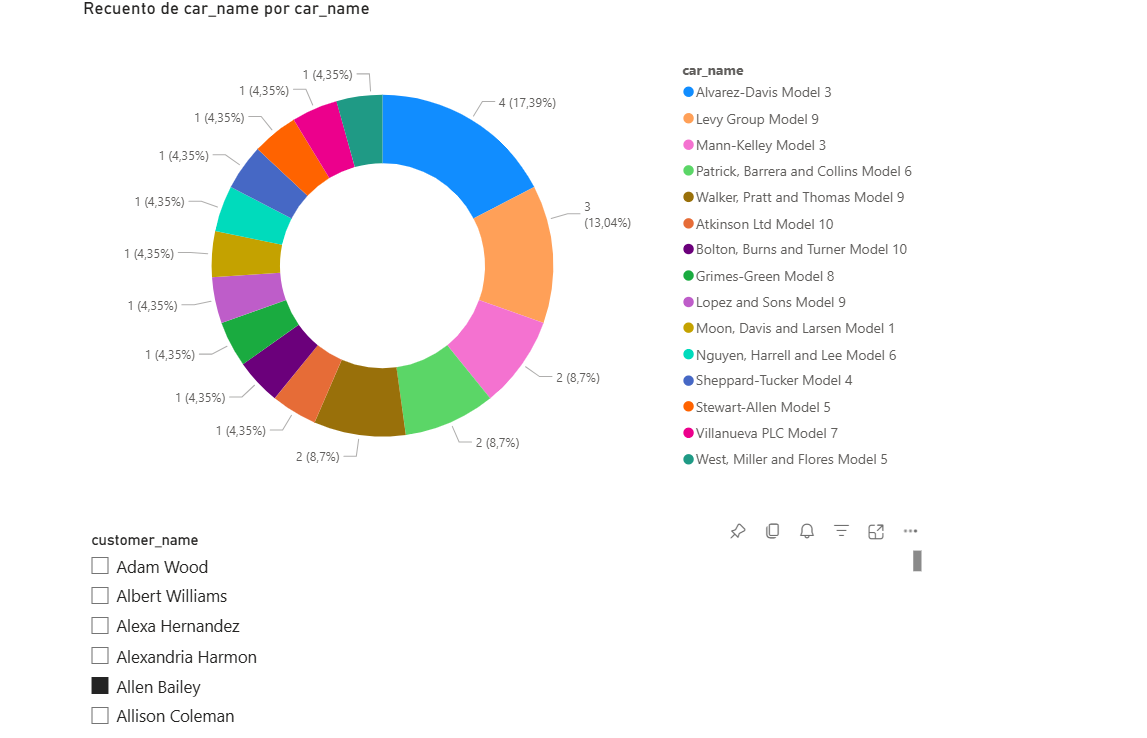